# SHRED at scale

This tutorial shows how to use the [SHallow REcurrent Decoders](link) at scale. It consists on four different steps which entail the parallel reduction of the data and interpolation to the input sensors, the fit of the SHRED architecture, the evaluation and of the fitted SHRED configurations and finally the parallel reconstruction of the model using the POD coefficients predicted by SHRED.
Although this tutorial can be launched all together in serial when working with such a small dataset, when working at scale each of the following steps is thought to be executed in separate scripts. Therefore, at introduction of each part of the tutorial, the link to the full script will be provided.

## Step 1: parallel POD and sensor interpolation

This is the first step of the tutorial on how to use SHRED at scale. It consists on preparing large-scale data for the input (sensors) and output (POD coefficients) of the SHRED architecture. A script combining all chunks of code can be found [here](https://github.com/ArnauMiro/pyLowOrder/blob/120-add-shred/Examples/NN/SHRED/example_01_SVD_and_sensors_cylinder.py). This script can be executed with as many processors as needed because both the POD computation and the sensor interpolation are performed in parallel. 

In [2]:
from __future__ import print_function, division

import mpi4py
mpi4py.rc.recv_mprobe = False

import numpy as np
import pyLOM
import matplotlib.pyplot as plt
pyLOM.style_plots()

0 Warning! Import - NVTX not present!


Let's define the path to the pyLOM Dataset which we are going to work with and the list of dataset variables which we will use for this example. As you'll see later in the tutorial, both the sensor data and the POD coefficients have to be saved on dataset which is agnostic to the original partition (i.e. we need to use the nopartition=True), hence, we can only extract and save sensors of unidimensional variables and multidimensional fields will be omitted when saving in pyLOM format.

In [3]:
DATAFILE = '../../../../../Examples/DATA/CYLINDER.h5'
VARIABLE = 'VELOX'

Now it's time to load the mesh and dataset of the full-scale data

In [4]:
m = pyLOM.Mesh.load(DATAFILE)
d = pyLOM.Dataset.load(DATAFILE,ptable=m.partition_table)
t = d.get_variable('time')
N = t.shape[0]
pyLOM.pprint(0,'Number of available snapshots',N)

Number of available snapshots 151


Now it's time to split the dataset snapshots in training, validation and test. In this case the reconstruct mode splitting is used, therefore, the three different sets span the full data range

In [5]:
tridx, vaidx, teidx = d.split_data('time', mode='reconstruct')
pyLOM.pprint(0,'Number of training snapshots %i, validation snapshots %i, test snapshots %i' % (tridx.shape[0], vaidx.shape[0], teidx.shape[0]))

Number of training snapshots 106, validation snapshots 23, test snapshots 22


Next step is defining the number of sensors and the region of the domain in which we want them to be. In this case only the X and Y axis are bounded because the input data is two-dimensional but in three-dimensional cases the Z axis bounds should also be defined.

In [6]:
nsens  = 3     
x0, x1 = 0.5, 8 
y0, y1 = -1, 1  
bounds = np.array([x0,x1,y0,y1])

We are going to generate now the new pyLOM Dataset containing the sensor coordinates and the data values on them. In this case the sensors are an existing point of the full dataset which is randomly selected inside the bounds given by the user. The sensor dataset also contains the training, validation and tests masks.

In [7]:
dsens  = d.select_random_sensors(nsens, bounds, [VARIABLE])
print(dsens.xyz)
# Save the sensor dataset
dsens.save('sensors.h5', nopartition=True, mode='w')

[[ 4.62249443  0.08040201]
 [ 5.86525612 -0.16080402]
 [ 5.0233853   0.30150754]]


Once the input is prepared, it's time to prepare the POD coefficients for the output. To do so, the POD modes are computed for the training test and then the validation and test snapshots are projected into it. Then, we compute and save the POD modes of the training set. Note that the spatial modes and singular values are also saved as they will be needed to reconstruct the flow at the end of the tutorial. In this case we are computing 8 modes of the streamwise velocity fluctuations through randomized POD with 3 power iterations

In [8]:
Xtrai   = d.mask_field(VARIABLE, tridx)
PSI,S,V = pyLOM.POD.run(Xtrai,remove_mean=True,randomized=True,r=8,q=3)
pyLOM.POD.save('POD_trai_%s.h5'%VARIABLE,PSI,S,V,d.partition_table,nvars=1,pointData=d.point)

We can now project the validation and test snapshots to the training spatial modes. For the validation and test sets we only save their POD coefficients

In [9]:
## Fetch validation dataset and project POD modes
Xvali   = d.mask_field(VARIABLE, vaidx)
proj    = pyLOM.math.matmulp(PSI.T, Xvali)
Vvali   = pyLOM.math.matmul(pyLOM.math.diag(1/S), proj)
pyLOM.POD.save('POD_vali_%s.h5'%VARIABLE,None,None,Vvali,d.partition_table,nvars=1,pointData=d.point)
## Fetch test dataset and project POD modes
Xtest   = d.mask_field(VARIABLE, teidx)
proj    = pyLOM.math.matmulp(PSI.T, Xtest)
Vtest   = pyLOM.math.matmul(pyLOM.math.diag(1/S), proj)
pyLOM.POD.save('POD_test_%s.h5'%VARIABLE,None,None,Vtest,d.partition_table,nvars=1,pointData=d.point)

To finish this step, we plot the first POD coefficient for the training, validation and test snapshots

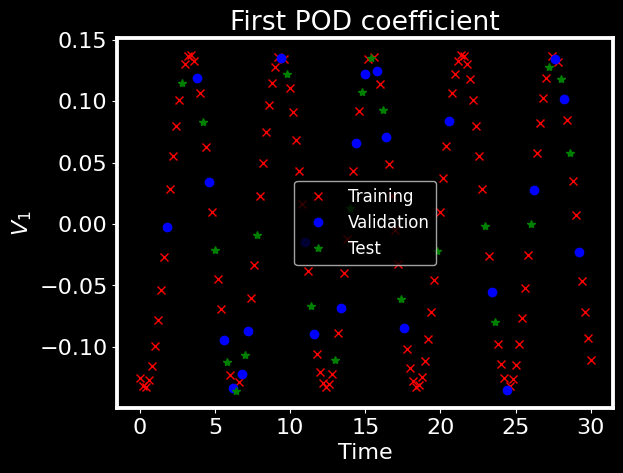

In [10]:
## Plot the first mode
plt.style.use('dark_background')
plt.figure()
plt.plot(t[tridx], V[0,:], 'rx', label='Training')
plt.plot(t[vaidx], Vvali[0,:], 'bo', label='Validation')
plt.plot(t[teidx], Vtest[0,:], 'g*', label='Test')
plt.xlabel('Time')
plt.ylabel(r'$V_1$')
plt.title('First POD coefficient')
plt.legend()

## Step 2: Fit SHRED

Once the data has been extracted and the POD has been computed, it is time to fit the SHRED model. This step is done in serial and the script combining all chunks of code can be found [here](https://github.com/ArnauMiro/pyLowOrder/blob/120-add-shred/Examples/NN/SHRED/example_02_fit_shred_cylinder.py). Note that this script ensambles different SHRED configurations for uncertainty quantification, but the core steps are the same as the ones in this tutorial.

In [11]:
import torch
import numpy as np
import pyLOM, pyLOM.NN

device = pyLOM.NN.select_device()

/home/benet/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We need to define first the variable that is measured in the sensors and the one that we'll be reconstructing

In [12]:
sensvar  = 'VELOX'    
podvar   = 'VELOX' 

We then define the paths where we'll save the output of SHRED. Including the input scalers, the POD scaler and the weights of each SHRED configuration

In [13]:
inscaler = 'scalers_config_'
outscale = 'scalers_pod.json'
shreds   = 'shreds_config_'

Now we need to load the sensor measurements that will be used for training, validation and test. Note that for each sensor we'll also load the snapshot ID (mask) and its time value

In [14]:
## Import sensor measurements
sensors   = pyLOM.Dataset.load('sensors.h5')
mask_trai = sensors.get_variable('training_time')
mask_vali = sensors.get_variable('validation_time')
mask_test = sensors.get_variable('test_time')
# Training
sens_trai = sensors.mask_field(sensvar, mask_trai).astype(np.float32)
nsens     = sens_trai.shape[0]
# Validation
sens_vali = sensors.mask_field(sensvar, mask_vali).astype(np.float32)
# Test
sens_test = sensors.mask_field(sensvar, mask_test).astype(np.float32)
# Compute total timesteps
time   = sensors.get_variable('time')
ntimeG = time.shape[0]

Now it's time to load the POD coefficients of the training set together with their corresponding singular values. The singular values will be used to penalize the SHRED loss function so that the model puts more effort in learning the higher energy modes.

In [15]:
S, pod_trai = pyLOM.POD.load('POD_trai_%s.h5' % podvar, vars=['S','V'])
pod_trai    = pod_trai.astype(np.float32)
output_size = pod_trai.shape[0]
Sscale      = S/np.sum(S)

A MinMaxScaler is created and fitted with the training POD data to scale the SHRED outputs between 0 and 1

In [16]:
pod_scaler  = pyLOM.NN.MinMaxScaler(column=True)
pod_scaler.fit(pod_trai)
pod_scaler.save(outscale)
trai_out    = pod_scaler.transform(pod_trai)

After the scaler is defined, the validation and test coefficients are loaded and transformed with it

In [17]:
# Validation
pod_vali = pyLOM.POD.load('POD_vali_%s.h5' % podvar, vars='V')[0].astype(np.float32)
vali_out = pod_scaler.transform(pod_vali)
# Test
pod_test = pyLOM.POD.load('POD_test_%s.h5' % podvar, vars='V')[0].astype(np.float32)
test_out = pod_scaler.transform(pod_test)

The full POD coefficients can be reensambled for any plotting purposes in the following way:

In [18]:
full_pod = np.zeros((output_size,ntimeG), dtype=pod_trai.dtype)
full_pod[:,mask_trai] = pod_trai
full_pod[:,mask_vali] = pod_vali
full_pod[:,mask_test] = pod_test

Now that we know the output size of the SHRED model (number of POD modes), we can generate the SHRED model. Note that the default hyperparameters are used in this case. A single sensor setup is used in this case, hence only a SHRED configuration will be generated.

In [19]:
shred     = pyLOM.NN.SHRED(output_size, device, nsens)
mysensors = shred.configs[0]
print(shred.configs)

[[2 1 0]]


Select the training, validation and test dataset of the sensors used in this configuration.

In [20]:
mytrai = sens_trai[mysensors,:]
myvali = sens_vali[mysensors,:]
mytest = sens_test[mysensors,:]

Scale the data of each sensor with a MinMaxScaler fitted on the training data. The MinMaxScaler is saved in a .json file.

In [21]:
myscaler = pyLOM.NN.MinMaxScaler(column=True)
scalpath = '%s%i.json' % (inscaler, 0)
myscaler.fit(mytrai)
myscaler.save(scalpath)
trai_sca = myscaler.transform(mytrai)
vali_sca = myscaler.transform(myvali)
test_sca = myscaler.transform(mytest)

The three different datasets are concatenated again to compute the time delay embedding

In [22]:
embedded = np.zeros((trai_sca.shape[0],ntimeG), dtype=trai_sca.dtype)
embedded[:,mask_trai] = trai_sca
embedded[:,mask_vali] = vali_sca
embedded[:,mask_test] = test_sca
delayed = pyLOM.math.time_delay_embedding(embedded, dimension=50)

The SHRED model is fitted and its weights are saved together with the ID of the input sensors and the path to the used scalers

In [23]:
train_dataset = pyLOM.NN.Dataset(trai_out, variables_in=delayed[:,mask_trai,:])
valid_dataset = pyLOM.NN.Dataset(vali_out, variables_in=delayed[:,mask_vali,:]) 
shred.fit(train_dataset, valid_dataset, epochs=1500, patience=100, verbose=False, mod_scale=torch.tensor(Sscale))
shred.save('%s%i' % (shreds,0), scalpath, outscale, mysensors)

Training done: Training loss = 0.29 Validation loss = 0.93 


## Step 3: inference SHRED

After training the SHRED models, it is time to evaluate their performance on reconstructing the POD coefficients. This step is also done in serial and reuses the results from the SHRED model fitted in the previous step. However, a script combining all chunks of code and working with N pre-trained SHRED configurations for uncertainty quantification can be found [here](https://github.com/ArnauMiro/pyLowOrder/blob/120-add-shred/Examples/NN/SHRED/example_03_inference_shred_cylinder.py).

We first evaluate the SHRED Model with the full dataset (including training, validation and test)

In [24]:
output = shred(torch.from_numpy(delayed).permute(1,2,0).to(device)).cpu().detach().numpy().T

Then, we rescale the output using the MinMaxScaler used to scale the POD coefficients so that we can compare the SHRED output with the original values. The comparison is done using the Mean Relative Error

In [25]:
outres = pod_scaler.inverse_transform(output)
MRE    = pyLOM.math.MRE_array(full_pod, outres)

We then save the predicted POD coefficients so that we can load them in the reconstruction step of the tutorial

In [26]:
pyLOM.POD.save('POD_predicted_%s.h5'% podvar,None, None, outres, d.partition_table,nvars=1)

We can evaluate the SHRED performance on the POD coefficients with a bar plot that represents the MRE for each of the modes

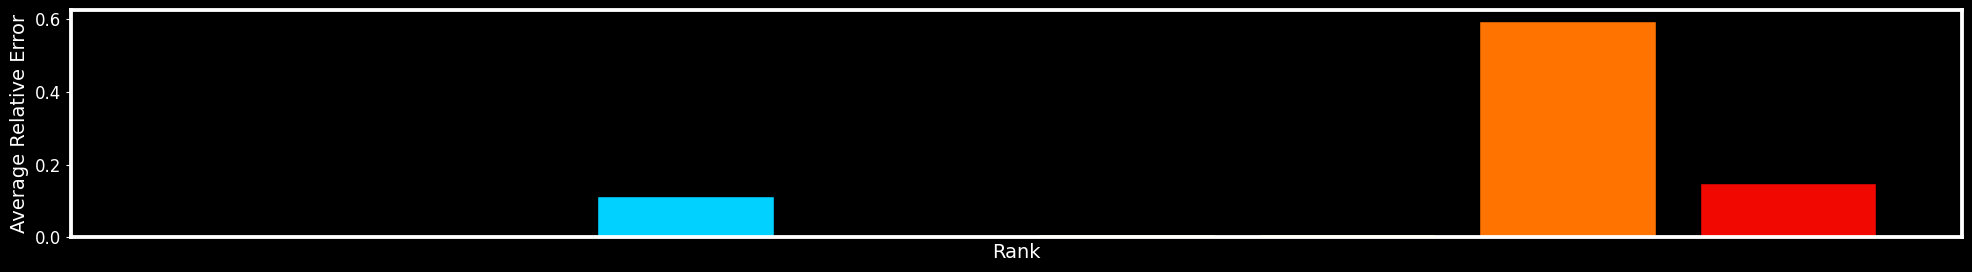

In [27]:
fig, _ = pyLOM.utils.plotModalErrorBars(MRE)

And by comparing the prediction of the time evolution of each of the modes with their original values

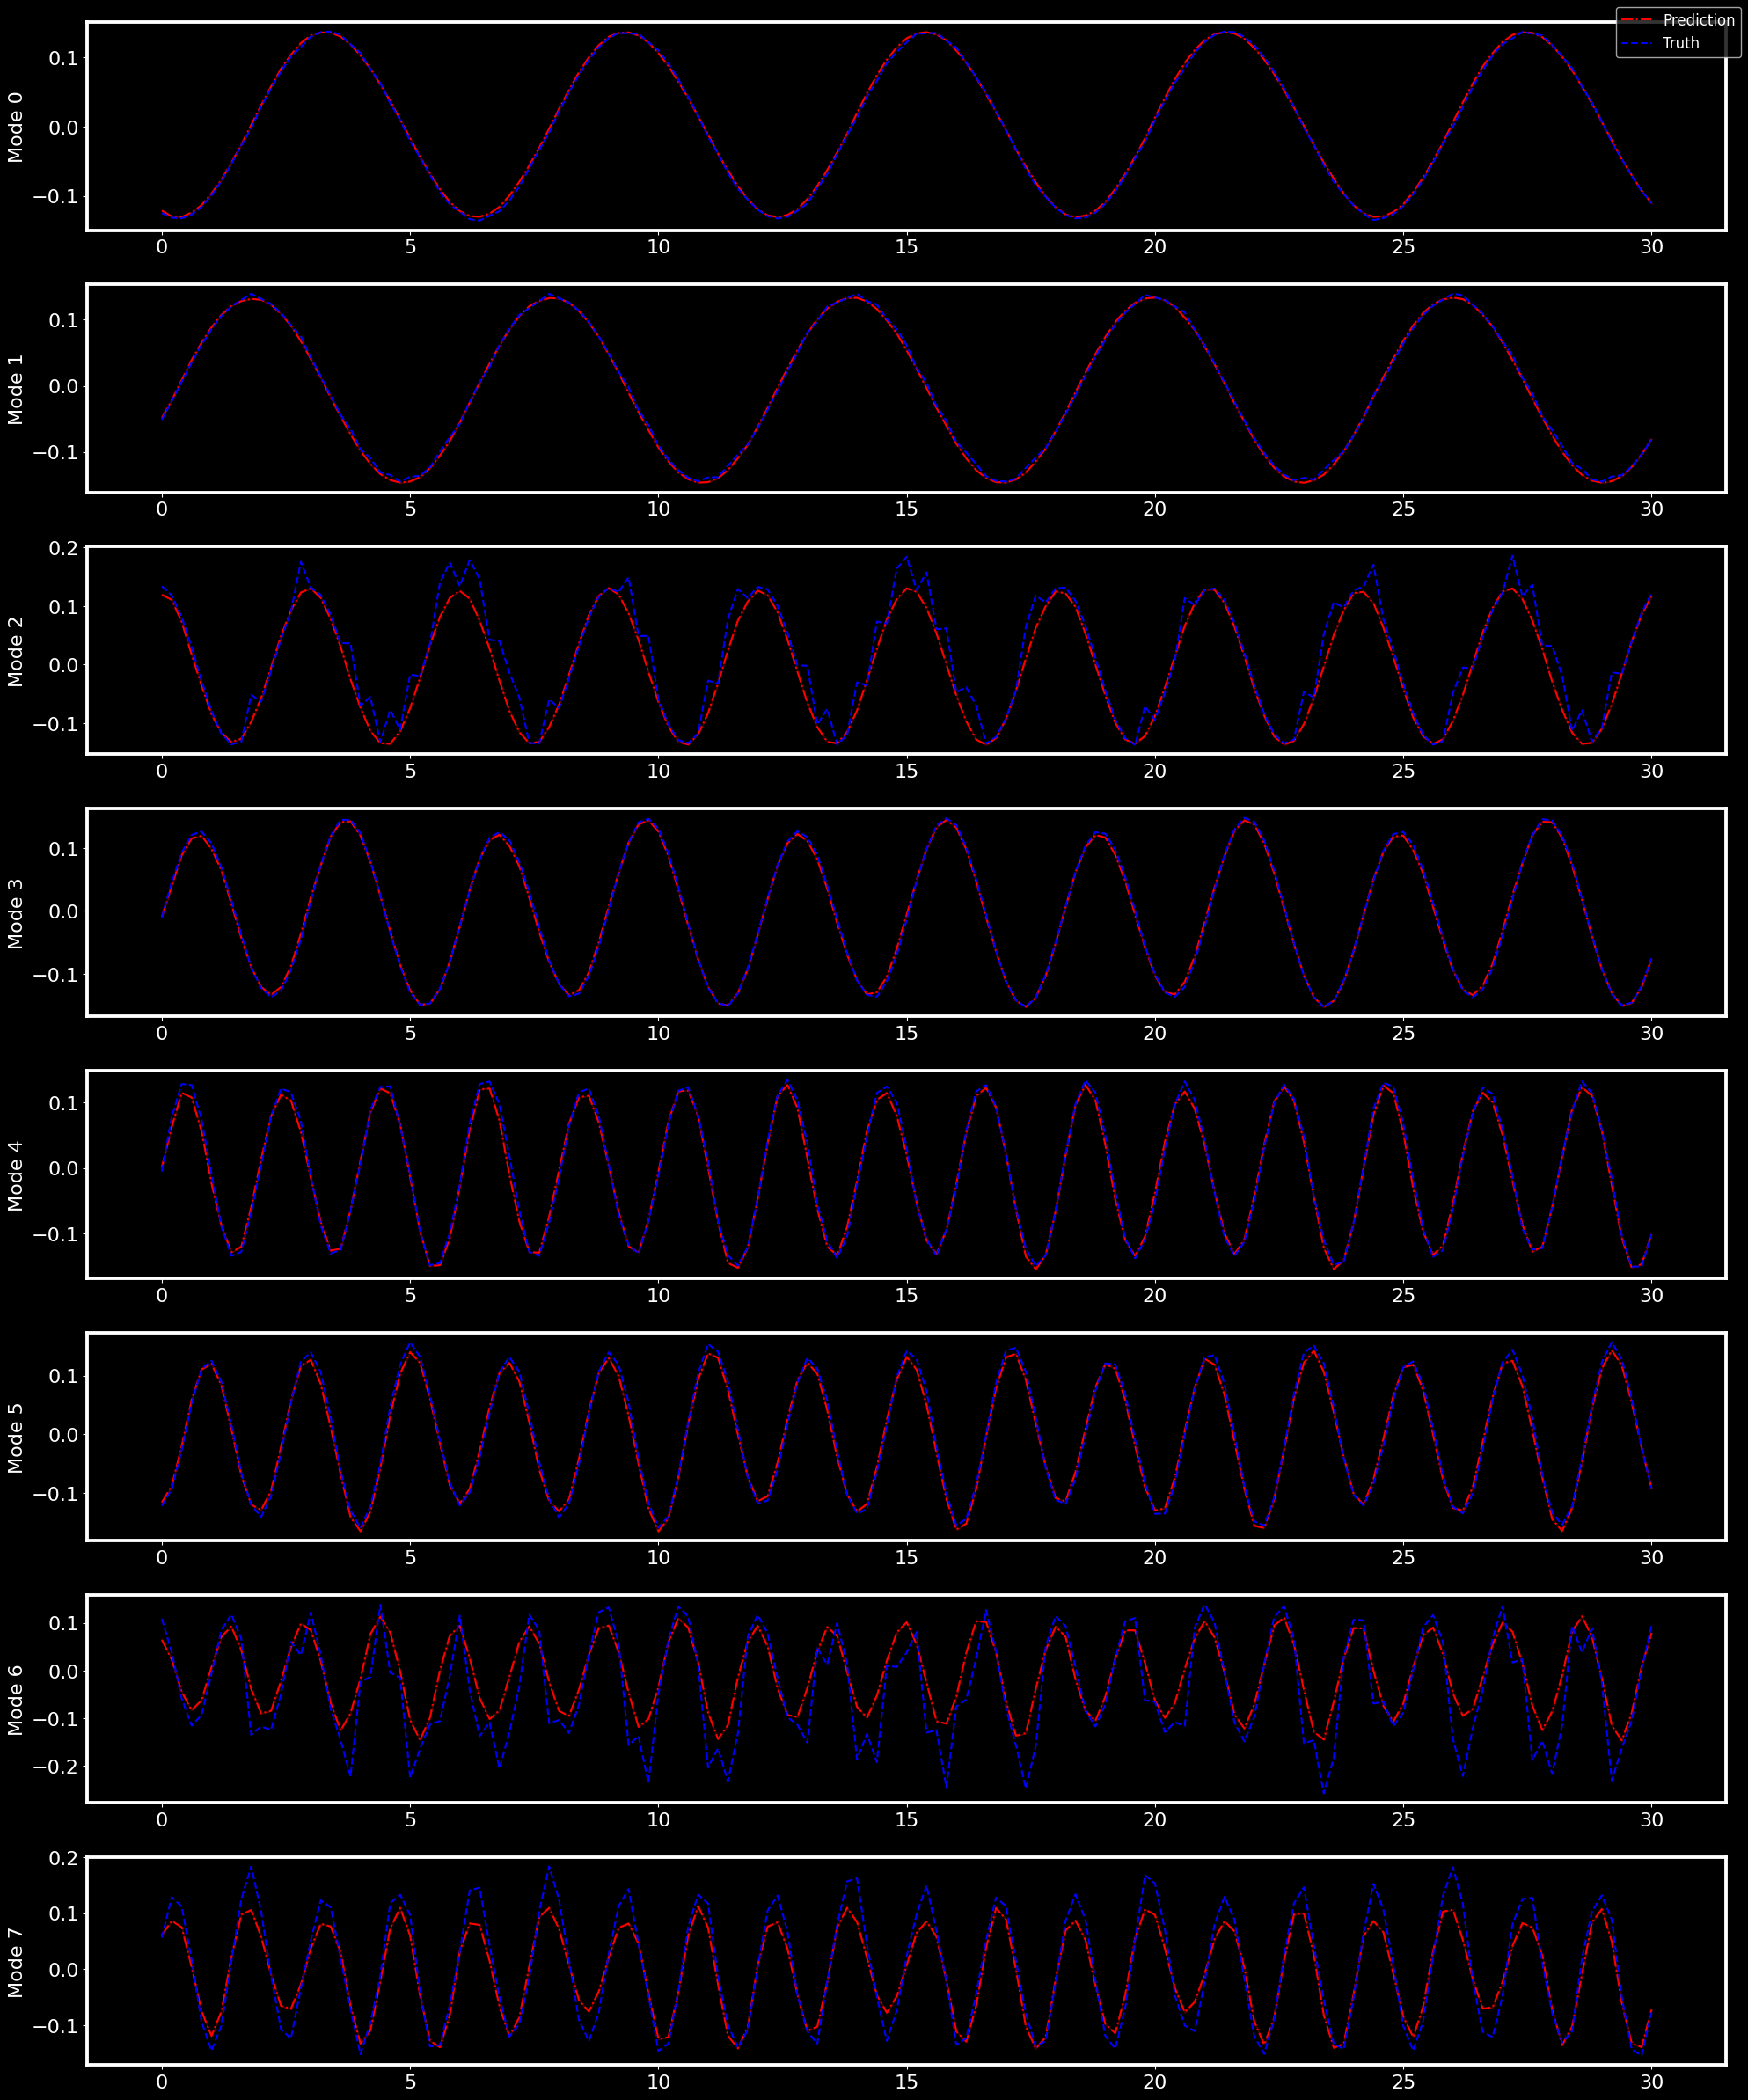

In [28]:
fig, _ = pyLOM.utils.plotTimeSeries(time, full_pod, outres)

## Step 4: parallel reconstruction

The last step is loading the predicted POD coefficients and reconstructing the flow to evaluate its error regarding the original field. This part of the tutorial needs to be executed with the same amount of processors as Step 1 (where we extracted the data from the sensors and computed the POD). A script combining all chunks of code can be found [here](https://github.com/ArnauMiro/pyLowOrder/blob/120-add-shred/Examples/NN/SHRED/example_01_SVD_and_sensors_cylinder.py). Note that this script reloads the original dataset, the training POD modes and the predicted POD coefficients by SHRED, but in this case we can just reuse the computed ones.

We start by reconstructing the field from the training POD modes and singular values and then add the temporal mean of the original dataset (remember that until now we have been working with the fluctuations).

In [29]:
X_POD  = pyLOM.POD.reconstruct(PSI,S,outres)
mean   = pyLOM.math.temporal_mean(d[VARIABLE])
X_PODm = pyLOM.math.subtract_mean(X_POD, -1*mean)

We compute the root mean square error between the original field and the reconstruction

In [30]:
rmse = pyLOM.math.RMSE(X_PODm,d[VARIABLE])
pyLOM.pprint(0,'RMSE = %e'%rmse)

RMSE = 9.365563e-03


Then, we add the reconstruction to the dataset so that we can plot the snapshots (serial cases) or save them to visualize them afterwards using any parallel visualization tool such as ParaView.

/home/benet/.local/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


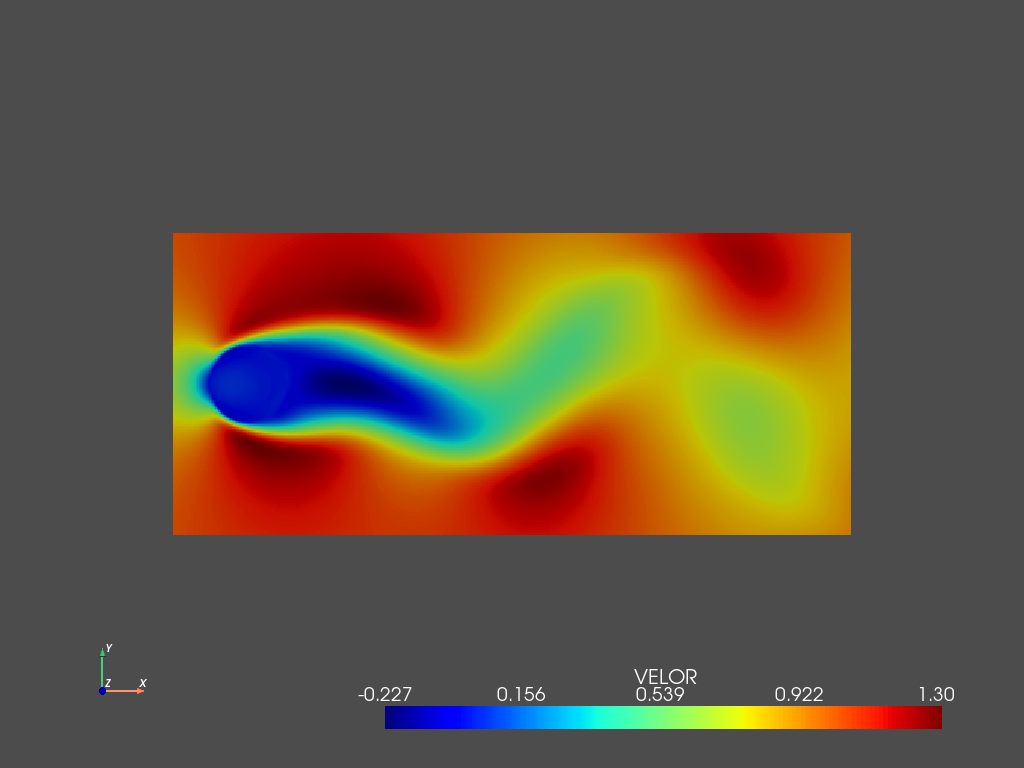

In [31]:
d.add_field('VELOR',1,X_PODm)
pyLOM.POD.plotSnapshot(m,d.to_cpu(['VELOR']),vars=['VELOR'],instant=teidx[0],component=0,cmap='jet',cpos='xy')

We can compare it with the original flow at the same time instant (the first one in the test set)

/home/benet/.local/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


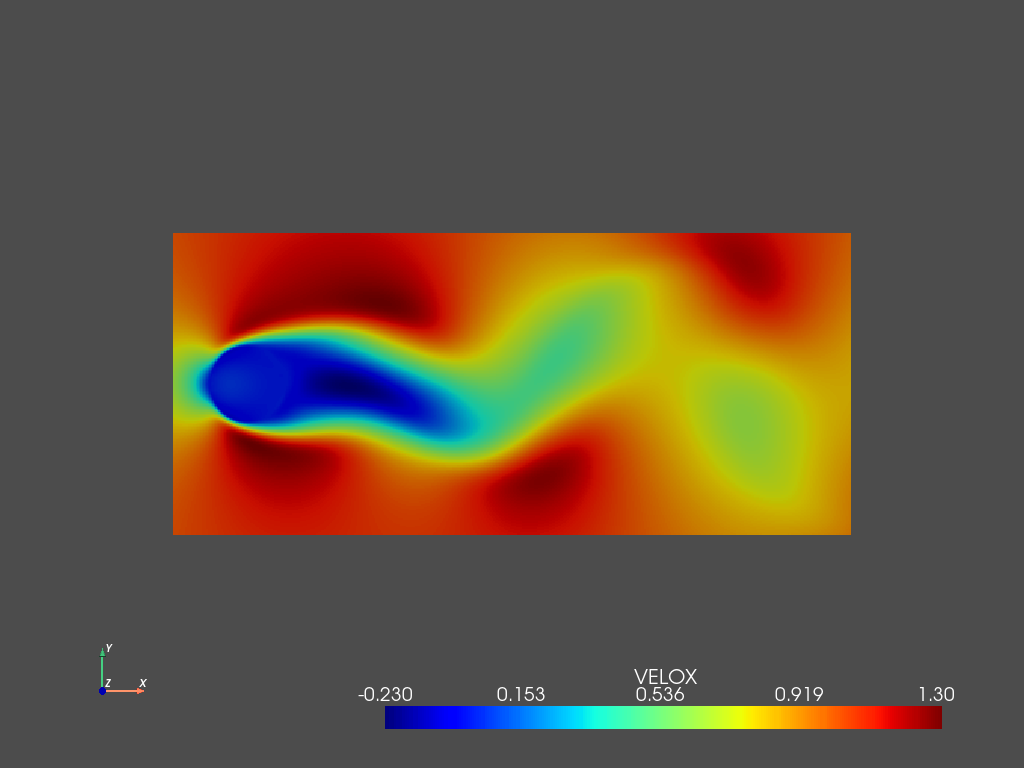

In [32]:
pyLOM.POD.plotSnapshot(m,d.to_cpu(['VELOX']),vars=['VELOX'],instant=teidx[0],component=0,cmap='jet',cpos='xy')